In [1]:
import warnings
warnings.simplefilter("ignore",category=DeprecationWarning)

In [9]:
import time
import pandas as pd
import numpy as np
import qiskit
import matplotlib.pyplot as plt
from qiskit import BasicAer
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, EfficientSU2
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, QNSPSA
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR, QSVR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from IPython.display import clear_output
from qiskit.utils import QuantumInstance

In [10]:
test_size = 0.6
y_feature = 'resale_price'

In [11]:
data = pd.read_csv('original_data.csv')
X = data.drop(columns=y_feature)
y = data[y_feature]

In [12]:
def list_of_lists_to_dataframe(data):
    columns = data[0]
    data = data[1:]
    df = pd.DataFrame(data, columns=columns)
    return df

In [13]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [14]:
#from qiskit_ibm_runtime import Estimator, QiskitRuntimeService, Session

#service = QiskitRuntimeService(
#     channel='ibm_quantum',
#    instance='ibm-q/open/main',
#    token='84e47768480771b0f65f16b3f25447e5ab6b88d174cccb8271d1d0a3e4fdf3ce875e7f9f2612ad64f6f107644f49d8c6d9cd2619469de103753b4ae7556e703a'
#)
#backend = service.backend('ibmq_qasm_simulator')
#estimator = Estimator(backend=backend)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='<IBM Quantum API key>')

## Using NeuralNetworkRegressor

#### Using QNNCircuit

In [ ]:
from sklearn import metrics
import subprocess  
import platform
import cpuinfo
from sklearn.model_selection import train_test_split
# Get CPU information
cpu_info = cpuinfo.get_cpu_info()

# Extract CPU name from the information
cpu = cpu_info['brand_raw']
dict = [['fit_time','predict_time', 'score_time', 'score', 'MAE', 'MSE', 'RMSE','feature', 'cpu'] ]
for i in range(19):
    newAr = []

    #data
    X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=X.iloc[:, :i-19]), y, test_size=test_size, random_state=101)

    #Scaling down data
    columns = X_train.columns.tolist()

    scaler = MinMaxScaler()
    X_train[columns] = scaler.fit_transform(X_train[columns])
    y_train = scaler.fit_transform(y_train.to_numpy().reshape(-1,1))
    X_test[columns] = scaler.fit_transform(X_test[columns])
    y_test = scaler.fit_transform(y_test.to_numpy().reshape(-1,1))


    #QNN
    qc = QNNCircuit(num_qubits=np.abs(i-19)) #number of features

    objective_func_vals = []
    regression_estimator_qnn = EstimatorQNN(circuit=qc)
    regressor = NeuralNetworkRegressor(neural_network=regression_estimator_qnn,
                                   loss='squared_error',
                                   optimizer=L_BFGS_B(maxiter=10),callback=callback_graph)
    start_time = time.time()
    regressor.fit(X_train,y_train)
    elapsed_time = time.time() - start_time
    newAr.append(elapsed_time *1000000)

    start_time = time.time()
    predicted_test_labels = regressor.predict(X_test)
    elapsed_time = time.time() - start_time
    newAr.append(elapsed_time *1000000)

    start_time = time.time()
    regressor.score(X_test,y_test)
    elapsed_time = time.time() - start_time
    newAr.append(elapsed_time *1000000)
    newAr.append(score)

    newAr.append(metrics.mean_absolute_error(y_test, y_pred))
    newAr.append(metrics.mean_squared_error(y_test, y_pred))
    newAr.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    newAr.append(len(X.drop(columns=X.iloc[:, :i-19]).columns))
    newAr.append(cpu)
    print(len(X.drop(columns=X.iloc[:, :i-19]).columns))
    dict.append(newAr)

rr = list_of_lists_to_dataframe(dict)
rr.to_csv('NNR_windows.csv',  encoding='utf-8', index=False)

In [ ]:
plt.scatter(test_labels,predicted_test_labels)

## Using VQR

#### Using RealAmplitudes ansatz

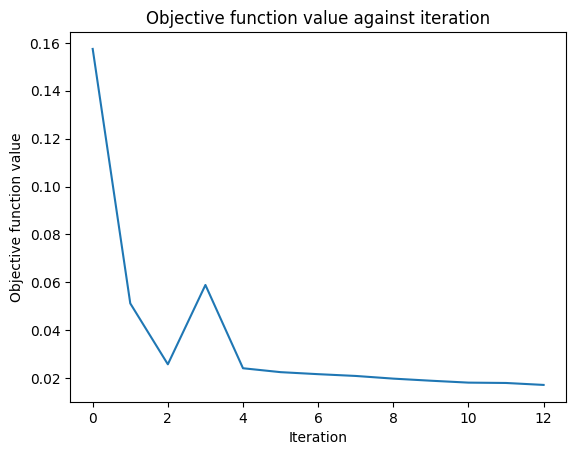

9


In [22]:
from sklearn import metrics
import subprocess  
import platform
from sklearn.model_selection import train_test_split
# Get CPU information
try:
    # Run the lscpu command to get CPU information on Linux/macOS
    info = subprocess.check_output(["lscpu"]).decode("utf-8").strip()
    # Extract CPU name from the lscpu output
    cpu = [line.split(':')[1].strip() for line in info.splitlines() if "Model name" in line][0]
except subprocess.CalledProcessError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

dict = [['fit_time','predict_time', 'score_time', 'score', 'MAE', 'MSE', 'RMSE','feature', 'cpu'] ]
for i in range(2,11):
    newAr = []

    #data
    X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=X.iloc[:, :-i]), y, test_size=test_size, random_state=101)

    #Scaling down data
    columns = X_train.columns.tolist()

    scaler = MinMaxScaler()
    X_train[columns] = scaler.fit_transform(X_train[columns])
    y_train = scaler.fit_transform(y_train.to_numpy().reshape(-1,1))
    X_test[columns] = scaler.fit_transform(X_test[columns])
    y_test = scaler.fit_transform(y_test.to_numpy().reshape(-1,1))

    #VQR
    feature_map = ZZFeatureMap(np.abs(i),reps=1,insert_barriers='True')
    ansatz = RealAmplitudes(np.abs(i),reps=3)
    objective_func_vals = []
    vqr = VQR(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=L_BFGS_B(maxiter=10),callback=callback_graph)

    starttime = time.time()
    vqr.fit(X_train,y_train)
    elapsed_time = time.time() - starttime
    newAr.append(elapsed_time *1000000)

    starttime = time.time()
    y_pred = vqr.predict(X_test)
    elapsed_time=time.time() - starttime
    newAr.append(elapsed_time *1000000)
    
    starttime=time.time()
    score = vqr.score(X_test,y_test)
    elapsed_time=time.time() - starttime
    newAr.append(elapsed_time *1000000)
    newAr.append(score)
    
    newAr.append(metrics.mean_absolute_error(y_test, y_pred))
    newAr.append(metrics.mean_squared_error(y_test, y_pred))
    newAr.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    newAr.append(len(X.drop(columns=X.iloc[:, :-i]).columns))
    newAr.append(cpu)
    print(len(X.drop(columns=X.iloc[:, :-i]).columns))
    dict.append(newAr)

rr = list_of_lists_to_dataframe(dict)
rr.to_csv('VQR_RA_windows.csv',  encoding='utf-8', index=False)

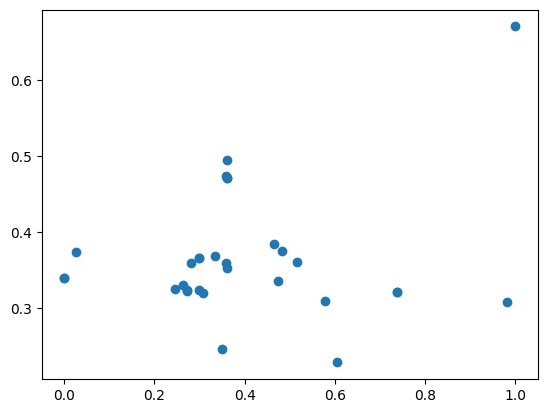

In [23]:
plt.scatter(y_test,y_pred)

#### Using EfficientSU2 ansatz

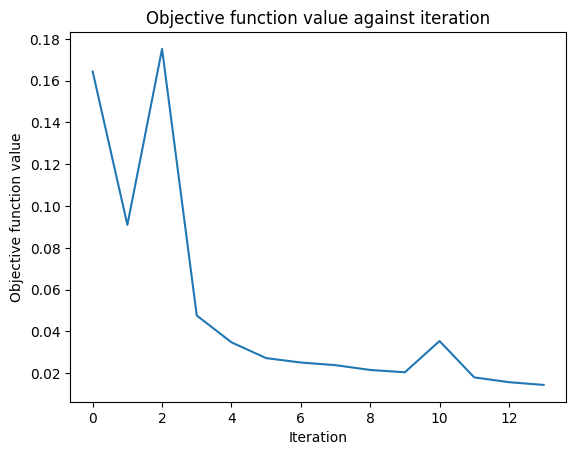

10


In [25]:
# Get CPU information
try:
    # Run the lscpu command to get CPU information on Linux/macOS
    info = subprocess.check_output(["lscpu"]).decode("utf-8").strip()
    # Extract CPU name from the lscpu output
    cpu = [line.split(':')[1].strip() for line in info.splitlines() if "Model name" in line][0]
except subprocess.CalledProcessError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

dict = [['fit_time','predict_time', 'score_time', 'score', 'MAE', 'MSE', 'RMSE','feature', 'cpu'] ]
for i in range(2,11):
    newAr = []

    #data
    X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=X.iloc[:, :-i]), y, test_size=test_size, random_state=101)

    #Scaling down data
    columns = X_train.columns.tolist()

    scaler = MinMaxScaler()
    X_train[columns] = scaler.fit_transform(X_train[columns])
    y_train = scaler.fit_transform(y_train.to_numpy().reshape(-1,1))
    X_test[columns] = scaler.fit_transform(X_test[columns])
    y_test = scaler.fit_transform(y_test.to_numpy().reshape(-1,1))

    #VQR
    feature_map = ZZFeatureMap(np.abs(i),reps=1,insert_barriers='True')
    ansatz = EfficientSU2(np.abs(i),reps=3)
    objective_func_vals = []
    vqr = VQR(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=L_BFGS_B(maxiter=10),callback=callback_graph)

    starttime = time.time()
    vqr.fit(X_train,y_train)
    elapsed_time = time.time()-starttime
    newAr.append(elapsed_time *1000000)

    starttime = time.time()
    y_pred = vqr.predict(X_test)
    elapsed_time=time.time()-starttime
    newAr.append(elapsed_time *1000000)
    
    starttime=time.time()
    score = vqr.score(X_test,y_test)
    elapsed_time=time.time()-starttime
    newAr.append(elapsed_time *1000000)
    newAr.append(score)
    
    newAr.append(metrics.mean_absolute_error(y_test, y_pred))
    newAr.append(metrics.mean_squared_error(y_test, y_pred))
    newAr.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    newAr.append(len(X.drop(columns=X.iloc[:, :-i]).columns))
    newAr.append(cpu)
    print(len(X.drop(columns=X.iloc[:, :-i]).columns))
    dict.append(newAr)

rr = list_of_lists_to_dataframe(dict)
rr.to_csv('VQR_ESU2_windows.csv',  encoding='utf-8', index=False)

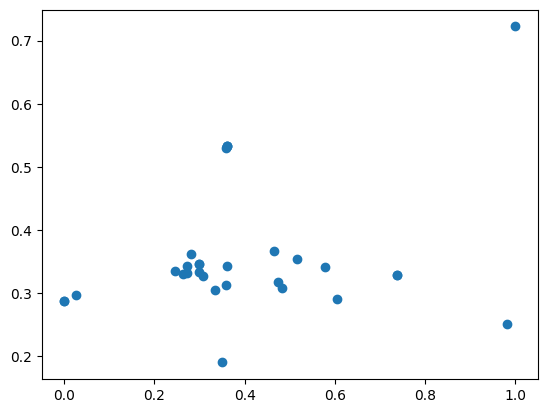

In [26]:
plt.scatter(y_test,y_pred)

## Using QSVR

In [27]:
from sklearn import metrics
import subprocess
import platform
from sklearn.model_selection import train_test_split
try:
    # Run the lscpu command to get CPU information on Linux/macOS
    info = subprocess.check_output(["lscpu"]).decode("utf-8").strip()
    # Extract CPU name from the lscpu output
    cpu = [line.split(':')[1].strip() for line in info.splitlines() if "Model name" in line][0]
except subprocess.CalledProcessError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

dict = [['fit_time','predict_time', 'score_time', 'score', 'MAE', 'MSE', 'RMSE','feature', 'cpu'] ]
for i in range(2,11):
    newAr = []

    #data
    X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=X.iloc[:, :-i]), y, test_size=test_size, random_state=101)

    #Scaling down data
    columns = X_train.columns.tolist()

    scaler = MinMaxScaler()
    X_train[columns] = scaler.fit_transform(X_train[columns])
    y_train = scaler.fit_transform(y_train.to_numpy().reshape(-1,1))
    X_test[columns] = scaler.fit_transform(X_test[columns])
    y_test = scaler.fit_transform(y_test.to_numpy().reshape(-1,1))


    feature_map = ZZFeatureMap(np.abs(i),reps=1,insert_barriers='True')

    objective_func_vals = []
    qsvr = QSVR()

    starttime = time.time()
    qsvr.fit(X_train,y_train)
    elapsed_time = time.time()-starttime
    newAr.append(elapsed_time *1000000)

    starttime = time.time()
    y_pred = qsvr.predict(X_test)
    elapsed_time=time.time()-starttime
    newAr.append(elapsed_time *1000000)

    starttime=time.time()
    score = qsvr.score(X_test,y_test)
    elapsed_time=time.time()-starttime
    newAr.append(elapsed_time *1000000)
    newAr.append(score)

    newAr.append(metrics.mean_absolute_error(y_test, y_pred))
    newAr.append(metrics.mean_squared_error(y_test, y_pred))
    newAr.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    newAr.append(len(X.drop(columns=X.iloc[:, :-i]).columns))
    newAr.append(cpu)
    print(len(X.drop(columns=X.iloc[:, :-i]).columns))
    dict.append(newAr)

rr = list_of_lists_to_dataframe(dict)
rr.to_csv('QSVR_windows.csv',  encoding='utf-8', index=False)

/home/akashm/mambaforge/envs/qc/lib/python3.11/site-packages/sklearn/svm/_base.py:292: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)


2


/home/akashm/mambaforge/envs/qc/lib/python3.11/site-packages/sklearn/svm/_base.py:292: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)


3


/home/akashm/mambaforge/envs/qc/lib/python3.11/site-packages/sklearn/svm/_base.py:292: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)


4


/home/akashm/mambaforge/envs/qc/lib/python3.11/site-packages/sklearn/svm/_base.py:292: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)


5


/home/akashm/mambaforge/envs/qc/lib/python3.11/site-packages/sklearn/svm/_base.py:292: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)


6


/home/akashm/mambaforge/envs/qc/lib/python3.11/site-packages/sklearn/svm/_base.py:292: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)


7


/home/akashm/mambaforge/envs/qc/lib/python3.11/site-packages/sklearn/svm/_base.py:292: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)


8


/home/akashm/mambaforge/envs/qc/lib/python3.11/site-packages/sklearn/svm/_base.py:292: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)


9


/home/akashm/mambaforge/envs/qc/lib/python3.11/site-packages/sklearn/svm/_base.py:292: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)


10


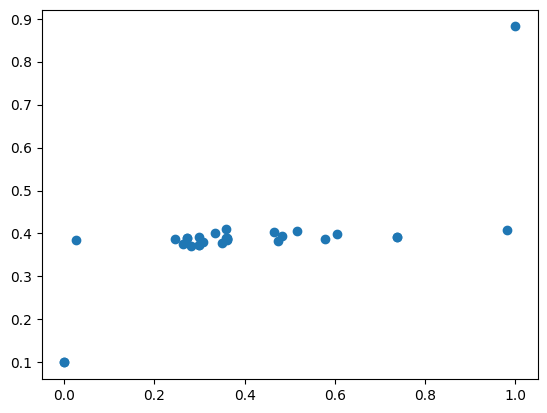

In [28]:
plt.scatter(y_test,y_pred)

In [17]:
mae_qsvr = mean_absolute_error(y_true=test_labels,y_pred=predicted_qsvr_test_labels)
print(f'Mean absolute error for QSVR :{mae_qsvr}')

Mean absolute error for QSVR :0.15961190718327603
